In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as ro
from functools import partial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.ipython import html
html.html_rdataframe = partial(html.html_rdataframe, table_class = "docutils")
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
%%R
library(mlbench)
datasetxor <- mlbench.xor(300)
XR_datasetxor <- datasetxor$x
LABELSR_datasetxor<- datasetxor$classes

In [6]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
x_df_xor = np.array(ro.r['XR_datasetxor'])
labels_df_xor = np.array(ro.r['LABELSR_datasetxor'])
labels_df_xor[labels_df_xor == 1] = -1
labels_df_xor[labels_df_xor == 2] = 1

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_df_xor, labels_df_xor, random_state = 0, train_size = 0.7)

In [10]:
def train_ELM_without_REG(xin : np.ndarray, yin : np.ndarray, p : int, control : bool) -> list:
    
    n = xin.shape[1] # Pegando o número de valores de cada entrada.

    # Z[n ou n + 1, p]
    if control == True:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range((n + 1) * p)]).reshape(n + 1, p)# Z[n + 1, p]
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin,ones), axis = 1) # xin[N, n + 1]
    else:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range(n * p)]).reshape(n , p)

    
    # A saída da rede é obtida com a pseudoinversa.
    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1) 
    w = np.dot(np.linalg.pinv(H), yin)
    print(f" w : {w}")

    # Retornos.
    return_list = list()
    return_list.append(w)   
    return_list.append(H)
    return_list.append(Z) # Conexões são desligadas apenas no treino, portanto tenho que mandar a matriz Z completa.
    return  return_list


def test_ELM(xin: np.ndarray, Z: np.ndarray, W: np.ndarray, control: bool):
    
    if control == True:
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin, ones), axis = 1)
        
    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)
    
    Y_hat = np.sign(np.dot(H, W)) # Para problemas de classificação.
    #Y_hat = np.dot(H, W) # Para problemas de regressão.
    return Y_hat

In [11]:
p_neurons = 200
ret = train_ELM_without_REG(xin = X_train, yin = y_train, p = p_neurons, control = True)
wxor = ret[0]
hxor = ret[1]
zxor = ret[2]

 w : [ 1.44172970e+11  3.11632037e+11 -2.46340450e+11  9.11277734e+10
  1.57194437e+11 -3.13569946e+11  7.76043635e+11  6.20353602e+11
 -2.17919351e+11 -6.42344633e+11 -4.94581227e+11 -2.30688868e+11
 -6.70569431e+11  4.22854413e+11  1.00260798e+11 -4.66202368e+09
  6.95493325e+11 -3.28237565e+10 -2.13623741e+11  2.45262026e+11
  1.29897018e+11 -1.63067351e+11 -3.77398806e+11 -7.78883810e+09
  4.10346520e+11 -6.08899699e+10  3.91110423e+10 -2.32110068e+11
  8.58967423e+10 -1.87727025e+11  4.83271987e+10 -1.72785423e+09
  8.86492284e+10 -8.30507083e+11  6.50154390e+11 -9.13897480e+10
  4.96956175e+11  6.24858950e+11  1.13220853e+11 -3.02263507e+11
 -2.14239142e+09  7.66377863e+10 -1.09336333e+11  4.43415080e+11
 -1.24617457e+12  1.84542650e+12  2.31992318e+11  2.72936599e+11
  1.12271704e+12  3.82271299e+10 -6.51258451e+10 -2.73234843e+11
  8.64627927e+11  7.56455832e+10  1.39446755e+10 -5.29237653e+11
 -1.08647063e+12 -4.06058837e+11 -7.80409958e+11 -2.59211299e+10
  4.15051474e+11 -6.

In [13]:
yhat_test = test_ELM(X_test, zxor, wxor, control = True)

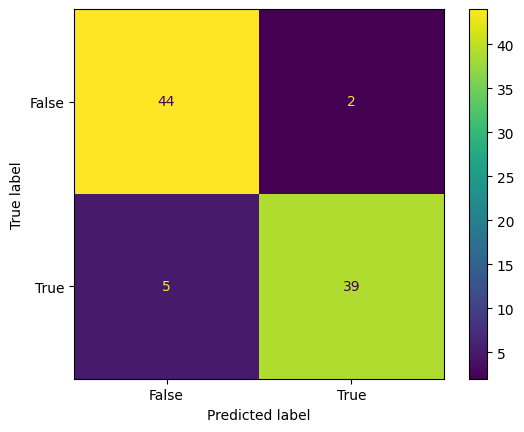

In [15]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, yhat_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [17]:
labels_df_reshaped = labels_df_xor.reshape(-1, 1)
mat_plot = np.concatenate((x_df_xor, labels_df_reshaped), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]

[]

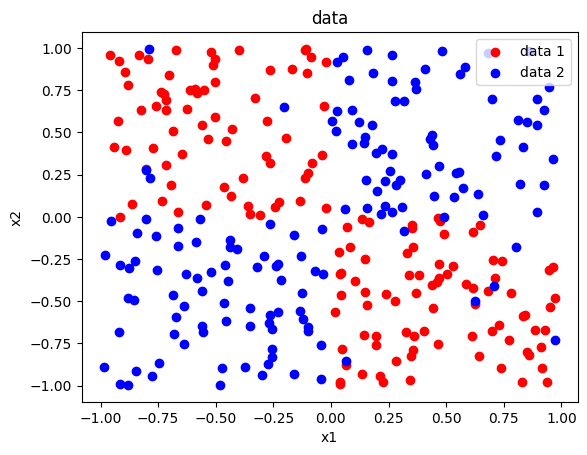

In [19]:
x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data 1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data 2')
plt.title('data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.plot()

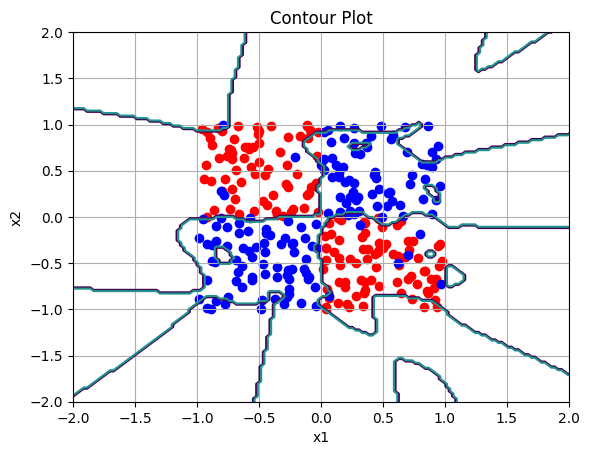

In [20]:
seqx1x2 = np.linspace(start = -4, stop = 4, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2, 1))
        h1 = np.tanh(np.dot(x1x2, zxor))
        h1 = np.column_stack((h1, np.ones_like(h1[:, 0])))
        MZ[i, j] = np.sign(np.dot(h1, wxor))[0]


plt.contour(seqx1x2, seqx1x2, MZ, levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

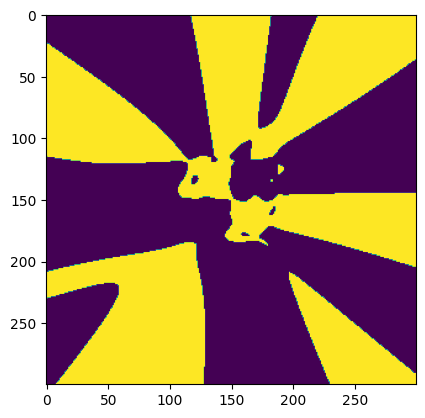

In [22]:
plt.imshow(MZ)

In [12]:
from sklearn.metrics import accuracy_score

p_neurons_grid = 0
lst_n_neurons = list()
lst_accuracy = list()
lst_z_val = list()
lst_w_val = list()


while p_neurons_grid < 1000:
    ret_grid = train_ELM_without_REG(xin = X_train, yin = y_train, p = p_neurons_grid, control = True)
    w_grid = ret_grid[0]
    h_grid = ret_grid[1]
    z_grid = ret_grid[2]

    # Testando o modelo.
    y_hatest = test_ELM(X_test, z_grid, w_grid, True)
    accuracy_test = accuracy_score(y_hatest, y_test)

    lst_n_neurons.append(p_neurons_grid)
    lst_w_val.append(w_grid)
    lst_z_val.append(z_grid)
    lst_accuracy.append(accuracy_test)
    p_neurons_grid += 1

In [13]:
lst_accuracy = np.array(lst_accuracy)
idx = np.argmax(lst_accuracy)
best_n_neurons = np.array(lst_n_neurons[idx])

print(f"So, using {best_n_neurons} neurons we have the best accuracy that was {lst_accuracy[idx]}.")
w_plot = np.array(lst_w_val[idx])
z_plot = np.array(lst_z_val[idx])

So, using 5 neurons we have the best accuracy that was 0.9777777777777777.


[]

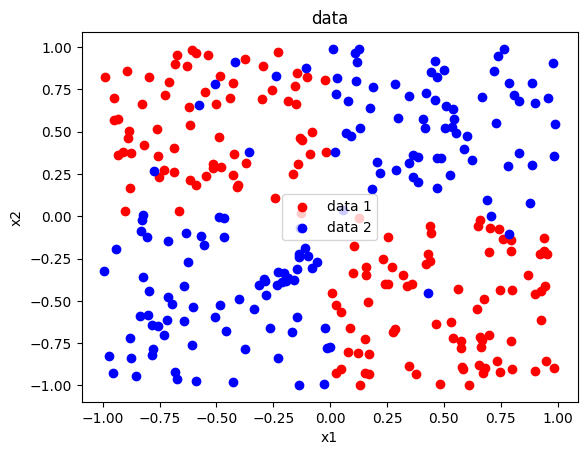

In [14]:
x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data 1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data 2')
plt.title('data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.plot()

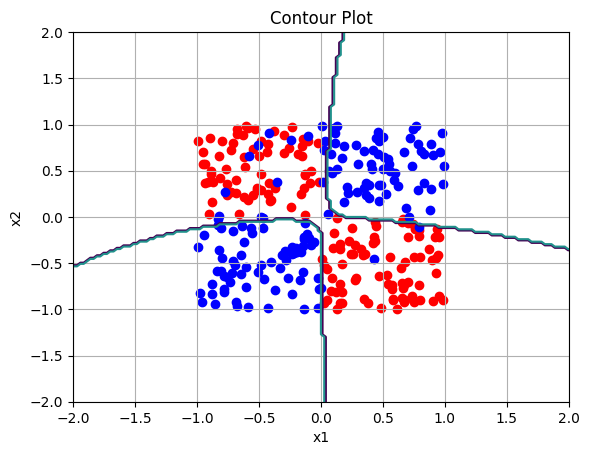

In [15]:
seqx1x2 = np.linspace(start = -4, stop = 4, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2, 1))
        h1 = np.tanh(np.dot(x1x2, z_plot))
        h1 = np.column_stack((h1, np.ones_like(h1[:, 0])))
        MZ[i, j] = np.sign(np.dot(h1, w_plot))[0]


plt.contour(seqx1x2, seqx1x2, MZ, levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()